In [23]:
import pandas as pd
import numpy as np 
import gc
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer # Why can't this be integrated with the previous cell
import nltk 
import string
import re 
from nltk.corpus import stopwords
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Category20
from bokeh.layouts import layout


data=pd.read_csv('midas-data.csv')
gc.collect()

2712

In [24]:
data.dropna(inplace=True)
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        text = text.lower().strip()
        text = " ".join(tokens)
    return text

data['cleaned'] = data['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
data['cleaned']=data['cleaned'].str.lower()

Now, that the abstract has been pre processed, it is time to  convert it into a format 
that can be handled by our algorithms. For this purpose, we will be using tf-idf.  The tf-idf which stands for term frequency - invrse document frequency, converts the corpus to a numerical format 
by bringing out specific terms, weighing very rare or  very common terms differently in order to assign them a low score. 

In [25]:
def vectorize(text):
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(text)
    return X

In [27]:
text = data['cleaned'].values

X = vectorize(text)

 We will apply the t-distributed stochastic neighbourhood embedding (t-SNE) to reduce the complexity of our dimensionality reduction step and filter noise.  

In [48]:
tsne = TSNE(verbose=1, perplexity=50)  
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 398 samples in 0.024s...
[t-SNE] Computed neighbors for 398 samples in 0.757s...
[t-SNE] Computed conditional probabilities for sample 398 / 398
[t-SNE] Mean sigma: 0.701574


/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.829857


/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1000 iterations: 0.471719


K means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly intalized centroid. The centroids are updated iteratively. 

To find the best value for k-means we will look athe disortion at different k values. 

When we plot disortion against k, there will be a k value after which decreases in disortion are minimal. These are the desired clusters.

In [32]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_embedded)
    k_means.fit(X_embedded)
    distortions.append(sum(np.min(cdist(X_embedded, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))
    print(distortions)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

Found distortion for 2 clusters
[8.413246676804242]
Found distortion for 3 clusters
[8.413246676804242, 7.074224692827318]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

Found distortion for 4 clusters
[8.413246676804242, 7.074224692827318, 6.207844998471816]
Found distortion for 5 clusters
[8.413246676804242, 7.074224692827318, 6.207844998471816, 5.6291296787750875]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

Found distortion for 6 clusters
[8.413246676804242, 7.074224692827318, 6.207844998471816, 5.6291296787750875, 5.095171122178999]
Found distortion for 7 clusters
[8.413246676804242, 7.074224692827318, 6.207844998471816, 5.6291296787750875, 5.095171122178999, 4.756172518517556]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

Found distortion for 8 clusters
[8.413246676804242, 7.074224692827318, 6.207844998471816, 5.6291296787750875, 5.095171122178999, 4.756172518517556, 4.431766920608667]
Found distortion for 9 clusters
[8.413246676804242, 7.074224692827318, 6.207844998471816, 5.6291296787750875, 5.095171122178999, 4.756172518517556, 4.431766920608667, 4.191264869496754]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

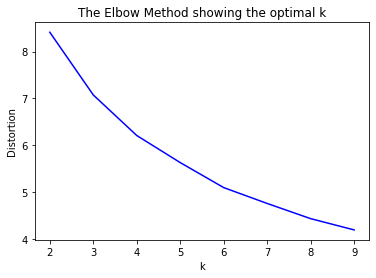

In [33]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
#plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [50]:
k=8
kmeans=KMeans(n_clusters=k,random_state=42)

y_pred=kmeans.fit_predict(X_embedded)
data['y']=y_pred
print(data['y'])

6       7
16      7
27      5
31      5
35      3
       ..
4301    3
4317    3
4343    1
4351    7
4362    4
Name: y, Length: 398, dtype: int32


/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

In [36]:
vectorizers = []
    
for ii in range(0,8 ):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=0, max_df=0.9))

In [37]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(data.loc[data['y'] == current_cluster, 'cleaned']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [38]:
#Topic modeling will be performed using the LDA. 
#This is a generateve statistical model that 
#allows sets of words to be explained by a shared topic. 
NUM_TOPICS_PER_CLUSTER = 8


lda_models = []

for ii in range(0, 8):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [39]:
#For each clyuster, we have created a corresponding LDA model. We will
#now fir_transform all the LDA models on their respective cluter vectors. 


clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7


In [40]:

def select_topics(model, vectorizer, top_n=3):
    curr_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in curr_words:
                keywords.append(word)
                curr_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for i in keywords:
        return_values.append(i[0])
    return return_values

In [41]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(select_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7


In [42]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

Loading BokehJS ...

In [43]:
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= data['titles'],
    journal = data['periodicals'],
    links = data['urls'],
    labels = ["C-" + str(x) for x in y_labels]
    ))


# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Journal", "@journal"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

In [44]:
# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature", 
           toolbar_location="above")

In [45]:

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

In [53]:


l = layout([
    [plot],
])
l.sizing_mode = "scale_both"


# show
output_file('Covid-19_Literature-Dashboard.html')
show(l)